In [54]:
import sys
sys.path.append('../')
import json
import string
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
import word2vecReader as godin_embedding
import fasttext
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input,Dense,Flatten,Dropout,Embedding
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.optimizers import Adam
from keras.layers.merge import concatenate
import keras.backend as K
from sklearn.model_selection import StratifiedKFold
from random import uniform,choice
from os import remove
import re
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from pprint import pprint
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12,10]

In [55]:
def load_data_from_file(filename):
    with open(filename,'r', errors='ignore') as fin:
        lines = fin.readlines()
    label = [int(x.split()[0]) for x in lines]
    sentence = [' '.join(x.split()[1:]) for x in lines]
    return label,sentence

In [56]:
train_labels,train_sentences = load_data_from_file('dataset/sst1/stsa.fine.train')
dev_label,dev_sentence = load_data_from_file('dataset/sst1/stsa.fine.dev')

In [57]:
train_sentences = train_sentences+dev_sentence
train_labels = train_labels+dev_label

In [58]:
len(train_labels),len(train_sentences)

(9645, 9645)

In [59]:
number_of_classes = len(set(train_labels))
number_of_classes

5

In [60]:
def remove_punctuation(s):
    list_punctuation = list(string.punctuation)
    for i in list_punctuation:
        s = s.replace(i,'')
    return s

In [61]:
def clean_sentence(sentence):
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"\@(\w+)", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    # should have used translate but for some reason it breaks on my server
    tokens = [remove_punctuation(w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [62]:
print("cleaning train data")
trainX = np.array([clean_sentence(s) for s in train_sentences])
trainY = np.array(train_labels)

cleaning train data


In [63]:
lengths = [len(line.split()) for line in trainX]

30


(array([ 503., 1766., 2173., 2127., 1592.,  883.,  415.,  156.,   22.,
           8.]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <a list of 10 Patch objects>)

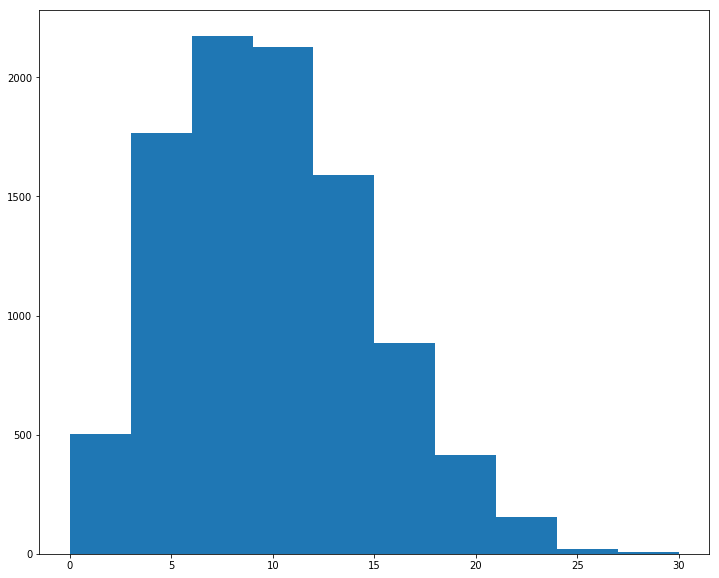

In [64]:
print(max(lengths))
plt.hist(lengths)

In [65]:
max_len = 24

In [66]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [67]:
def encode_text(tokenizer, lines, length):
    encoded = tokenizer.texts_to_sequences(lines)
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [68]:
def load_GloVe_embedding(file_name):
    print('Loading GloVe word vectors.')
    embeddings_index = dict()
    f = open(file_name)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index

In [69]:
def get_GloVe_embedding_matrix(embeddings_index):
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [70]:
def load_fast_text_model(sentences):
    try:
        m = fasttext.load_model('fast_text_model.bin')
        print("trained model loaded")
        return m
    except:
        print("traning new model")
        with open('temp_file.txt','w') as temp_file:
            for sentence in sentences:
                temp_file.write(sentence)
        m = fasttext.cbow('temp_file.txt','fast_text_model')
        remove('temp_file.txt')
        print('model trained')
        return m


In [73]:
def load_godin_word_embedding(path):
    print("Loading Goding model.")
    return godin_embedding.Word2Vec.load_word2vec_format(path, binary=True)

In [75]:
def load_google_word2vec(file_name):
    print("Loading google news word2vec")
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [78]:
def get_word_embedding_matrix(model,dim):
    #dim = 300 for google word2vec
    #dim = 400 for godin
    #dim = 100 for fast text
    embedding_matrix = np.zeros((vocab_size,dim))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix